In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


In [1]:
%%time
!conda install alignn chgnet matgl pytorch torchvision torchaudio pytorch-cuda -c pytorch -c nvidia -y --quiet

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.

CPU times: user 546 ms, sys: 80.2 ms, total: 626 ms
Wall time: 1min 11s


In [2]:
!git clone https://github.com/ACEsuit/mace.git

fatal: destination path 'mace' already exists and is not an empty directory.


In [3]:
pip install ./mace

Processing ./mace
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mace-torch: filename=mace_torch-0.3.6-py3-none-any.whl size=114647 sha256=90059f1cc1eb01fc25abd8d15d19eb4b7fa0771f80447bc71e645e5b8bed5f6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-1sejvnlo/wheels/df/5f/32/ef59561725170a81c728fd01c75e56a9ee83bad6da485fc6a5
Successfully built mace-torch
  Attempting uninstall: mace-torch
    Found existing installation: mace-torch 0.3.6
    Uninstalling mace-torch-0.3.6:
      Successfully uninstalled mace-torch-0.3.6


In [4]:
pip install phonopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for phonopy: filename=phonopy-2.26.6-cp310-cp310-linux_x86_64.whl size=498282 sha256=5cf6ad0db128ebb79ae7f4567e630f62789fb8b2d8c1bb23684ce6b8f4acdd8b
  Stored in directory: /root/.cache/pip/wheels/f4/ed/06/0176a42c0a6748ca0710e307e749d6d94b8baf3bc9d2f547a1
Successfully built phonopy


In [5]:
!conda install -c conda-forge phono3py

Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - phono3py


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openblas-0.3.27            |pthreads_h9eca1d5_1         5.5 MB  conda-forge
    phono3py-3.3.2             |  py310hfc14280_0         3.1 MB  conda-forge
    phonopy-2.26.6             |  py310h27b3328_0         1.6 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        10.2 MB

The following NEW packages will be INSTALLED:

  openblas   

In [6]:
!pip install -q git+https://github.com/usnistgov/intermat.git@develop

  Preparing metadata (setup.py) ... done


In [7]:
import alignn
import matgl
import chgnet
import mace

In [8]:
from jarvis.db.figshare import data, get_jid_data
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
indices_list = [[1, 0, 0],[1, 1, 1],[1,1,0],[0,1,1],[0,0,1],[0,1,0]]
def get_atoms(jid):
    dat = get_jid_data(jid=jid, dataset="dft_3d")
    return Atoms.from_dict(dat["atoms"])

In [9]:
from ase.optimize.fire import FIRE
from ase.constraints import ExpCellFilter
from jarvis.core.atoms import ase_to_atoms
from matgl.ext.ase import M3GNetCalculator
from alignn.ff.ff import AlignnAtomwiseCalculator, default_path
from chgnet.model.dynamics import CHGNetCalculator
model_filename='best_model.pt'
from mace.calculators import mace_mp

def setup_calculator(calculator_type):
    if calculator_type == "matgl":
        pot = matgl.load_model("M3GNet-MP-2021.2.8-PES")
        return M3GNetCalculator(pot)
    elif calculator_type == "alignn_ff":
        model_path = default_path()
        return AlignnAtomwiseCalculator(path=model_path,stress_wt=0.3,force_mult_natoms=False,force_multiplier=1,modl_filename=model_filename)
    elif calculator_type == "chgnet":
        return CHGNetCalculator()
    elif calculator_type == "mace":
        return mace_mp()
    else:
        raise ValueError("Unsupported calculator type")


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [10]:
import io
import contextlib
import re
def capture_fire_output(ase_atoms, fmax, steps):
    log_stream = io.StringIO()
    with contextlib.redirect_stdout(log_stream):
        dyn = FIRE(ase_atoms)
        dyn.run(fmax=fmax, steps=steps)
    output = log_stream.getvalue().strip()
    final_energy = None
    if output:
        last_line = output.split('\n')[-1]
        match = re.search(r'FIRE:\s+\d+\s+\d+:\d+:\d+\s+(-?\d+\.\d+)', last_line)
        if match:
            final_energy = float(match.group(1))
    return final_energy, dyn.nsteps

In [11]:
def relax_structure(atoms, calculator_type, fmax=0.05, steps=200, log_file=None, job_info=None):
    ase_atoms = atoms.ase_converter()
    calc = setup_calculator(calculator_type)
    ase_atoms.calc = calc
    ase_atoms = ExpCellFilter(ase_atoms)
    final_energy, nsteps = capture_fire_output(ase_atoms, fmax, steps)
    relaxed_atoms = ase_to_atoms(ase_atoms.atoms)
    converged = nsteps < steps
    if log_file:
        log_job_info(f"Final energy of FIRE optimization for structure: {final_energy}", log_file)
        log_job_info(f"Relaxation {'converged' if converged else 'did not converge'} within {steps} steps.", log_file)
    if job_info is not None:
        job_info["final_energy_structure"] = final_energy
        job_info["converged"] = converged
    return relaxed_atoms


In [12]:
import numpy as np
from ase.eos import EquationOfState
from ase.units import kJ
import matplotlib.pyplot as plt

def ev_curve(
    atoms=None,
    dx=np.arange(-0.05, 0.05, 0.01),
    calculator=None,
    on_relaxed_struct=False,
    stress_wt=1,
):
    """Get EV curve."""
    relaxed = atoms

    y = []
    vol = []
    for i in dx:
        s1 = relaxed.strain_atoms(i)
        ase_atoms = s1.ase_converter()
        ase_atoms.calc = calculator
        energy = ase_atoms.get_potential_energy()
        y.append(energy)
        vol.append(s1.volume)
    x = np.array(dx)
    y = np.array(y)
    eos = EquationOfState(vol, y, eos="murnaghan")
    v0, e0, B = eos.fit()
    kv = B / kJ * 1.0e24  # , 'GPa')
    print("Energies:", y)
    print("Volumes:", vol)
    return x, y, eos, kv

def calculate_ev_curve(atoms, calculator, dx=np.arange(-0.06, 0.06, 0.01)):
    x, y, eos, kv = ev_curve(atoms=atoms, dx=dx, calculator=calculator)
    v0, e0 = eos.v0, eos.e0  # Equilibrium volume and energy
    return x, y, eos, kv, e0, v0



In [13]:
import numpy as np
from phonopy import Phonopy
from phonopy.file_IO import write_FORCE_CONSTANTS
from jarvis.core.kpoints import Kpoints3D as Kpoints
from ase import Atoms as AseAtoms

def phonons_gen(
    atoms=None,
    calculator=None,
    dim=[2, 2, 2],
    freq_conversion_factor=33.3566830,  # Thz to cm-1
    phonopy_bands_figname="phonopy_bands.png",
    write_fc=False,
    min_freq_tol=-0.05,
    distance=0.2,
):
    """Make Phonon calculation setup."""
    if atoms is None or calculator is None:
        raise ValueError("Atoms and calculator must be provided")

    kpoints = Kpoints().kpath(atoms, line_density=5)
    bulk = atoms.phonopy_converter()
    phonon = Phonopy(bulk, [[dim[0], 0, 0], [0, dim[1], 0], [0, 0, dim[2]]])
    phonon.generate_displacements(distance=distance)
    supercells = phonon.get_supercells_with_displacements()
    set_of_forces = []
    for scell in supercells:
        ase_atoms = AseAtoms(
            symbols=scell.symbols,
            positions=scell.positions,
            cell=scell.cell,
            pbc=True,
        )
        ase_atoms.calc = calculator
        forces = np.array(ase_atoms.get_forces())
        drift_force = forces.sum(axis=0)
        for force in forces:
            force -= drift_force / forces.shape[0]
        set_of_forces.append(forces)

    phonon.produce_force_constants(forces=set_of_forces)
    if write_fc:
        write_FORCE_CONSTANTS(
            phonon.get_force_constants(), filename="FORCE_CONSTANTS"
        )

    lbls = kpoints.labels
    lbls_ticks = []
    freqs = []
    tmp_kp = []
    lbls_x = []
    count = 0
    for ii, k in enumerate(kpoints.kpts):
        k_str = ",".join(map(str, k))
        if ii == 0:
            tmp = []
            for i, freq in enumerate(phonon.get_frequencies(k)):
                tmp.append(freq)
            freqs.append(tmp)
            tmp_kp.append(k_str)
            lbl = "$" + str(lbls[ii]) + "$"
            lbls_ticks.append(lbl)
            lbls_x.append(count)
            count += 1
        elif k_str != tmp_kp[-1]:
            tmp_kp.append(k_str)
            tmp = []
            for i, freq in enumerate(phonon.get_frequencies(k)):
                tmp.append(freq)
            freqs.append(tmp)
            lbl = lbls[ii]
            if lbl != "":
                lbl = "$" + str(lbl) + "$"
                lbls_ticks.append(lbl)
                lbls_x.append(count)
            count += 1

    freqs = np.array(freqs)
    freqs = freqs * freq_conversion_factor
    the_grid = plt.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.0)
    plt.rcParams.update({"font.size": 18})
    plt.figure(figsize=(10, 5))
    plt.subplot(the_grid[0])
    for i in range(freqs.shape[1]):
        plt.plot(freqs[:, i], lw=2, c="b")
    for i in lbls_x:
        plt.axvline(x=i, c="black")
    plt.xticks(lbls_x, lbls_ticks)
    plt.ylabel("Frequency (cm$^{-1}$)")
    plt.xlim([0, max(lbls_x)])

    phonon.run_mesh([40, 40, 40], is_gamma_center=True, is_mesh_symmetry=False)
    phonon.run_total_dos()
    tdos = phonon._total_dos
    freqs, ds = tdos.get_dos()
    freqs = np.array(freqs)
    freqs = freqs * freq_conversion_factor
    min_freq = min_freq_tol * freq_conversion_factor
    max_freq = max(freqs)
    plt.ylim([min_freq, max_freq])

    plt.subplot(the_grid[1])
    plt.fill_between(
        ds, freqs, color=(0.2, 0.4, 0.6, 0.6), edgecolor="k", lw=1, y2=0
    )
    plt.xlabel("DOS")
    plt.yticks([])
    plt.xticks([])
    plt.ylim([min_freq, max_freq])
    plt.xlim([0, max(ds)])
    plt.tight_layout()
    plt.savefig(phonopy_bands_figname)
    #plt.show()
    plt.close()

    return phonon


In [22]:
import h5py
import shutil
import glob
def phonons3_gen(atoms=None, calculator=None, dim=[2, 2, 2], distance=0.2, force_multiplier=2, output_dir=""):
    """Make Phonon3 calculation setup."""
    from phono3py import Phono3py
    from ase import Atoms as AseAtoms
    import numpy as np
    import shutil

    ase_atoms = atoms.ase_converter()
    ase_atoms.calc = calculator

    bulk = atoms.phonopy_converter()
    phonon = Phono3py(bulk, [[dim[0], 0, 0], [0, dim[1], 0], [0, 0, dim[2]]])
    phonon.generate_displacements(distance=distance)
    supercells = phonon.supercells_with_displacements

    set_of_forces = []
    for scell in supercells:
        ase_atoms = AseAtoms(
            symbols=scell.get_chemical_symbols(),
            scaled_positions=scell.get_scaled_positions(),
            cell=scell.get_cell(),
            pbc=True,
        )
        ase_atoms.calc = calculator
        forces = np.array(ase_atoms.get_forces())
        drift_force = forces.sum(axis=0)
        for force in forces:
            force -= drift_force / forces.shape[0]
        set_of_forces.append(forces)

    forces = np.array(set_of_forces).reshape(-1, len(phonon.supercell), 3)
    phonon.forces = forces
    phonon.produce_fc3()
    phonon.mesh_numbers = 30
    phonon.init_phph_interaction()
    phonon.run_thermal_conductivity(
        temperatures=range(0, 1001, 10), write_kappa=True
    )
    kappa = phonon.thermal_conductivity.kappa
    print(f"Thermal conductivity: {kappa}")


    hdf5_file_pattern = "kappa-*.hdf5"
    for hdf5_file in glob.glob(hdf5_file_pattern):
        shutil.move(hdf5_file, os.path.join(output_dir, hdf5_file))

    return kappa

def convert_kappa_units(hdf5_filename, temperature_index):
    with h5py.File(hdf5_filename, 'r') as f:
        kappa_unit_conversion = f['kappa_unit_conversion'][()]
        heat_capacity = f['heat_capacity'][:]
        gv_by_gv = f['gv_by_gv'][:]
        gamma = f['gamma'][:]

        converted_kappa = kappa_unit_conversion * heat_capacity[temperature_index, 2, 0] * gv_by_gv[2, 0] / (2 * gamma[temperature_index, 2, 0])

        return converted_kappa

def process_phonon3_results(output_dir, log_file, job_info):
    file_pattern = os.path.join(output_dir, "kappa-*.hdf5")
    file_list = glob.glob(file_pattern)

    temperatures = np.arange(10, 101, 10)
    kappa_xx_values = []

    if file_list:
        hdf5_filename = file_list[0]
        log_job_info(f"Processing file: {hdf5_filename}", log_file)

        for temperature_index in temperatures:
            converted_kappa = convert_kappa_units(hdf5_filename, temperature_index)
            kappa_xx = converted_kappa[0]
            kappa_xx_values.append(kappa_xx)
            log_job_info(f"Temperature index {temperature_index}, converted kappa: {kappa_xx}", log_file)

        job_info['temperatures'] = temperatures.tolist()
        job_info['kappa_xx_values'] = kappa_xx_values

        plt.figure(figsize=(8, 6))
        plt.plot(temperatures * 10, kappa_xx_values, marker='o', linestyle='-', color='b')
        plt.xlabel('Temperature (K)')
        plt.ylabel('Converted Kappa (xx element)')
        plt.title('Temperature vs. Converted Kappa (xx element)')
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, 'Temperature_vs_Converted_Kappa.png'))
        plt.close()
    else:
        log_job_info("No files matching the pattern were found.", log_file)
def move_hdf5_files(output_dir):
    file_pattern = "kappa-*.hdf5"
    file_list = glob.glob(file_pattern)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for file in file_list:
        shutil.move(file, os.path.join(output_dir, os.path.basename(file)))


In [15]:
def relax_defect_structure(atoms, calculator_type, fmax=0.05, steps=200, log_file=None, job_info=None):
    ase_atoms = atoms.ase_converter()
    calculator = setup_calculator(calculator_type)
    ase_atoms.calc = calculator
    ase_atoms = ExpCellFilter(ase_atoms, constant_volume=True)
    final_energy, nsteps = capture_fire_output(ase_atoms, fmax, steps)
    relaxed_atoms = ase_to_atoms(ase_atoms.atoms)
    converged = nsteps < steps
    if log_file:
        log_job_info(f"Final energy of FIRE optimization for defect structure: {final_energy}", log_file)
        log_job_info(f"Defect relaxation {'converged' if converged else 'did not converge'} within {steps} steps.", log_file)
    if job_info is not None:
        job_info[f"final_energy_defect for {name}"] = final_energy
        job_info[f"converged for {name}"] = converged
    return relaxed_atoms

In [16]:
def relax_surface_structure(atoms, calculator_type, fmax=0.05, steps=200, log_file=None, job_info=None):
    ase_atoms = atoms.ase_converter()
    calculator = setup_calculator(calculator_type)
    ase_atoms.calc = calculator
    ase_atoms = ExpCellFilter(ase_atoms, constant_volume=True)
    final_energy, nsteps = capture_fire_output(ase_atoms, fmax, steps)
    relaxed_atoms = ase_to_atoms(ase_atoms.atoms)
    converged = nsteps < steps
    if log_file:
        log_job_info(f"Final energy of FIRE optimization for surface structure: {final_energy}", log_file)
        log_job_info(f"Surface relaxation {'converged' if converged else 'did not converge'} within {steps} steps.", log_file)
    if job_info is not None:
        job_info[f"final_energy_surface for {jid} with indices {indices}"] = final_energy
        job_info[f"converged for {jid} with indices {indices}"] = converged
    return relaxed_atoms

In [17]:
import subprocess
from jarvis.db.jsonutils import dumpjson
import os
from jarvis.db.jsonutils import loadjson

def perform_interface_scan(film_jid, substrate_jid, film_index, substrate_index, disp_intvl, calculator_method, output_dir, log_file):
    config = {
        "film_jid": film_jid,
        "substrate_jid": substrate_jid,
        "film_index": film_index,
        "substrate_index": substrate_index,
        "disp_intvl": disp_intvl,
        "calculator_method": calculator_method,
    }
    config_filename = os.path.join(output_dir, f"config_{film_jid}_{substrate_jid}_{calculator_method}.json")

    # Save config file
    dumpjson(data=config, filename=config_filename)
    log_job_info(f"Config file created: {config_filename}", log_file)

    # Run intermat script using subprocess
    command = f"run_intermat.py --config_file {config_filename}"
    log_job_info(f"Running command: {command}", log_file)
    try:
        result = subprocess.run(command, shell=True, check=True, capture_output=True, text=True)
        log_job_info(f"Command output: {result.stdout}", log_file)
    except subprocess.CalledProcessError as e:
        log_job_info(f"Command failed with error: {e.stderr}", log_file)
        return None, None

    main_results_filename = "intermat_results.json"
    output_results_filename = os.path.join(output_dir, main_results_filename)

    # Check if the results file was created in the main directory
    if not os.path.exists(main_results_filename):
        log_job_info(f"Results file not found: {main_results_filename}", log_file)
        return None, None


    os.rename(main_results_filename, output_results_filename)
    res = loadjson(output_results_filename)
    w_adhesion = res.get("wads", [])
    systems_info = res.get("systems", {})

    if "wads" in res:
        plt.contourf(res["wads"], cmap="plasma")
        plt.axis("off")
        plot_filename = os.path.join(output_dir, f"Interface_Scan_{film_jid}_{substrate_jid}_{calculator_method}.png")
        plt.savefig(plot_filename)
        plt.show()
        return output_results_filename, plot_filename, w_adhesion, systems_info
    else:
        log_job_info(f"No 'wads' key in results file: {output_results_filename}", log_file)
        return output_results_filename, None, w_adhesion, systems_info

In [30]:
import numpy as np
from ase import units
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.nvtberendsen import NVTBerendsen
from jarvis.core.atoms import ase_to_atoms, Atoms
from ase.io import write


def get_supercell_dims(atoms, target_atoms=200):
    n_atoms = len(atoms.elements)
    scale = np.ceil((target_atoms / n_atoms) ** (1/3))
    return [int(scale)] * 3

def general_melter(jid='', atoms=None, calculator=None, log_file=None, job_info=None, output_dir=""):
    if atoms is None or calculator is None:
        raise ValueError("Atoms and calculator must be provided")

    dim = get_supercell_dims(atoms)
    sup = atoms.make_supercell_matrix(dim)

    ase_atoms = sup.ase_converter()
    ase_atoms.calc = calculator

    dt = 1 * units.fs
    temp0, nsteps0 = 2000, 20 #2000
    temp1, nsteps1 = 300, 20 #2000
    taut = 20 * units.fs
    trj = os.path.join(output_dir, f'{jid}_melt.traj')

    MaxwellBoltzmannDistribution(ase_atoms, temp0 * units.kB)
    dyn = NVTBerendsen(ase_atoms, dt, temp0, taut=taut, trajectory=trj)

    def myprint():
        print(f'time={dyn.get_time() / units.fs: 5.0f} fs ' +
              f'T={ase_atoms.get_temperature(): 3.0f} K')

    dyn.attach(myprint, interval=20)
    dyn.run(nsteps0)

    dyn.set_temperature(temp1)
    dyn.run(nsteps1)

    final_atoms = ase_to_atoms(ase_atoms)
    poscar_filename = os.path.join(output_dir, f'POSCAR_{jid}_quenched_{calculator_type}.vasp')
    write(poscar_filename, final_atoms.ase_converter(), format='vasp')
    log_job_info(f'MD simulation completed. Final structure saved to {poscar_filename}', log_file)
    job_info["quenched_atoms"] = final_atoms.to_dict()

    return final_atoms

from ase.geometry.rdf import CellTooSmall

def calculate_rdf(ase_atoms, jid, calculator_type, output_dir, log_file, job_info, rmax=5.0, nbins=200):
    # Determine the minimum lattice constant of the structure
    min_lattice_constant = min(ase_atoms.get_cell().lengths())

    # Ensure rmax is less than the minimum lattice constant
    if rmax >= min_lattice_constant / 2:
        rmax = min_lattice_constant / 2
        log_job_info(f"Adjusted rmax to {rmax} based on the minimum lattice constant of the structure.", log_file)

    try:
        rdfs, distances = get_rdf(ase_atoms, rmax, nbins)
        plt.figure()
        plt.plot(distances, rdfs)
        plt.xlabel('Distance (Å)')
        plt.ylabel('RDF')
        plt.title(f'Radial Distribution Function for {jid} ({calculator_type})')
        rdf_plot_filename = os.path.join(output_dir, f'RDF_{jid}_{calculator_type}.png')
        plt.savefig(rdf_plot_filename)
        plt.show()
        job_info["rdf_plot"] = rdf_plot_filename
        log_job_info(f'RDF plot saved to {rdf_plot_filename}', log_file)
    except CellTooSmall as e:
        recommended_rmax = float(str(e).split('=')[-1].split()[0])
        log_job_info(f'CellTooSmall error: {e}. Adjusting rmax to {recommended_rmax}.', log_file)

        # Recalculate RDF with adjusted rmax
        rdfs, distances = get_rdf(ase_atoms, recommended_rmax, nbins)
        plt.figure()
        plt.plot(distances, rdfs)
        plt.xlabel('Distance (Å)')
        plt.ylabel('RDF')
        plt.title(f'Radial Distribution Function for {jid} ({calculator_type}) with adjusted rmax')
        rdf_plot_filename = os.path.join(output_dir, f'RDF_{jid}_{calculator_type}_adjusted.png')
        plt.savefig(rdf_plot_filename)
        plt.show()
        job_info["rdf_plot_adjusted"] = rdf_plot_filename
        log_job_info(f'Adjusted RDF plot saved to {rdf_plot_filename}', log_file)



In [ ]:
jids_check = [
    "JVASP-1002", # Si
    "JVASP-816", # Al
    "JVASP-867", # Cu
    "JVASP-1029", # Ti
    "JVASP-861", # Cr
    "JVASP-30", # GaN Pg3mmc
    "JVASP-8169", #GaN F-43m
    "JVASP-890", #Ge
    "JVASP-8158", #SiC F-43m
    "JVASP-8118", #SiC P6_3mmc
    "JVASP-107", #SiC P6_3mc
    "JVASP-39", #AlN P6_3mc
    "JVASP-7844", #AlN F-43m
    "JVASP-35106", #Al3GaN4 P-43m
    "JVASP-1174", #GaAs F-43m
    "JVASP-1372", #AlAs F-43m
    "JVASP-91", #C Fd-3m
    "JVASP-1186", #InAs F-43M
    "JVASP-1408", #AlSb F-43M
    "JVASP-105410", #SiGe F-43m
    "JVASP-1177", #GaSb F-43m
    "JVASP-79204", #BN P63mc
    "JVASP-1393", #GaP F-43m
    "JVASP-1312", #BP F-43m
    "JVASP-1327", #AlP F-43m
    "JVASP-1183", #InP F-43m
    "JVASP-1192", #CdSe F-43m
    "JVASP-8003", #CdS F-43m
    "JVASP-96", #ZnSe F-43m
    "JVASP-1198", #ZnTe F-43m
    "JVASP-1195", #ZnO P63mc
    "JVASP-9147", #HfO2 P21c
    "JVASP-41", #SiO2 P3_221
    "JVASP-34674", #SiO2 C222_1
    "JVASP-113", #ZrO2 P2_1c
    "JVASP-32", #Al2O3 R-3c
]

In [19]:
import json

def save_dict_to_json(data_dict, filename):
    with open(filename, 'w') as f:
        json.dump(data_dict, f, indent=4)

def load_dict_from_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

def log_job_info(message, log_file):
    with open(log_file, 'a') as f:
        f.write(message + "\n")
    print(message)

dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v5.27.2024
Processing with calculator: mace
Cached MACE model to /root/.cache/mace/5yyxdm76
Using Materials Project MACE for MACECalculator with /root/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/usr/local/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
Initial atoms for JVASP-1174: OrderedDict([('lattice_mat', [[3.509895098013499, -6.584084e-10, 2.026439508259945], [1.169965032050413, 3.3091606691404545, 2.026439508259945], [-1.8622597e-09, -1.3168164e-09, 4.052878022970947]]), ('coords', [[0.0, 0.0, 0.0], [1.1699675, 0.82729, 2.02644]]), ('elements', ['Ga', 'As']), ('abc', [4.052883, 4.052879, 4.05288]), ('angles', [60.0, 60.0, 59.9999]), ('cartesian', True), ('props', ['', ''])])
Using Materials Project MACE for MACECalculator with /root/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


<ipython-input-11-959639cb6c39>:5: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


Final energy of FIRE optimization for structure: -8.32086
Relaxation converged within 200 steps.
Relaxed structure for JVASP-1174: OrderedDict([('lattice_mat', [[3.512453464458849, -3.7483292994154357e-07, 2.0279159415700287], [1.1708174607627684, 3.311572216520302, 2.027915954261898], [-2.3469668878419619e-07, -1.5041132416382247e-07, 4.055831292145814]]), ('coords', [[1.4998231211405205e-07, -7.02513867207165e-09, 5.6297124564333356e-08], [1.1708199921539484, 0.8278927628624398, 2.027916481374743]]), ('elements', ['Ga', 'As']), ('abc', [4.055831, 4.055832, 4.05583]), ('angles', [59.9999, 59.9999, 59.9999]), ('cartesian', True), ('props', ['', ''])])
Energies: [-7.87893248 -8.03389168 -8.14797306 -8.22809601 -8.28072643 -8.31062031
 -8.32085991 -8.31364536 -8.29082108 -8.25401688 -8.20463943 -8.14387512]
Volumes: [39.18395682794096, 40.447859560689686, 41.73865283719066, 43.0566197157992, 44.40204325487057, 45.77520651276005, 47.176392547822935, 48.605884418414526, 50.063965182890094,

<ipython-input-13-659ed3ebc759>:25: DeprecationWarning: Phonopy.get_supercells_with_displacements() is deprecated.Use Phonopy.supercells_with_displacements attribute.
  supercells = phonon.get_supercells_with_displacements()
<ipython-input-13-659ed3ebc759>:95: DeprecationWarning: TotalDos.get_dos() is deprecated. Use frequency_points and dos attributes instead.
  freqs, ds = tdos.get_dos()


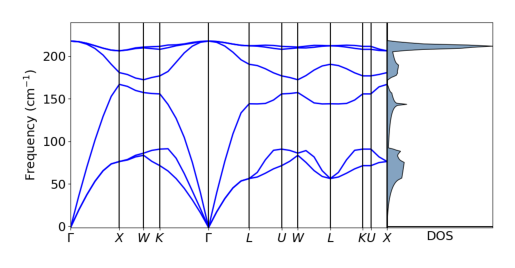

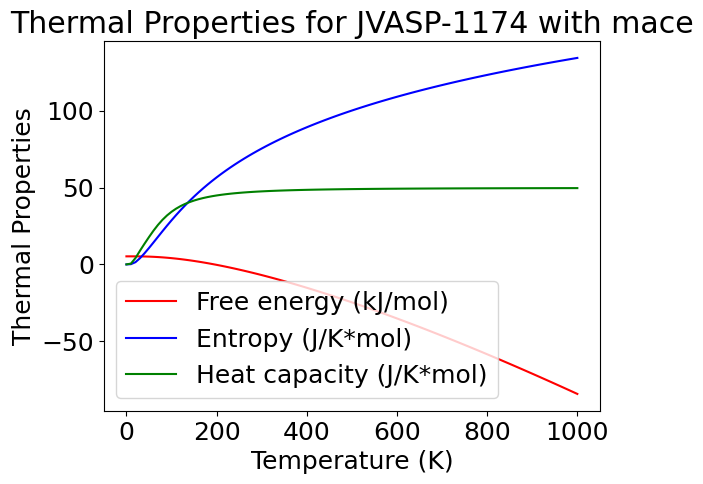

Zero-point energy for JVASP-1174 with mace: 0.05440858294866216 eV


<ipython-input-22-9baa7346a15a>:22: DeprecationWarning: PhonopyAtoms.get_chemical_symbols() is deprecated. Use symbols attribute instead.
  symbols=scell.get_chemical_symbols(),
<ipython-input-22-9baa7346a15a>:23: DeprecationWarning: PhonopyAtoms.get_scaled_positions() is deprecated. Use scaled_positions attribute instead.
  scaled_positions=scell.get_scaled_positions(),
<ipython-input-22-9baa7346a15a>:24: DeprecationWarning: PhonopyAtoms.get_cell() is deprecated. Use cell attribute instead.
  cell=scell.get_cell(),


Thermal conductivity: [[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 7.00050085e+02  7.00050340e+02  7.00050344e+02 -1.83659283e-05
   -1.83846834e-05  1.19434544e-04]
  [ 3.38623856e+02  3.38623979e+02  3.38623981e+02 -8.88385213e-06
   -8.89292427e-06  5.77721317e-05]
  [ 1.72390211e+02  1.72390273e+02  1.72390274e+02 -4.52268532e-06
   -4.52730385e-06  2.94112473e-05]
  [ 1.01618549e+02  1.01618586e+02  1.01618587e+02 -2.66597922e-06
   -2.66870171e-06  1.73369953e-05]
  [ 6.80188302e+01  6.80188550e+01  6.80188553e+01 -1.78448511e-06
   -1.78630742e-06  1.16045953e-05]
  [ 5.00196572e+01  5.00196755e+01  5.00196757e+01 -1.31227387e-06
   -1.31361396e-06  8.53378218e-06]
  [ 3.92913171e+01  3.92913314e+01  3.92913316e+01 -1.03081412e-06
   -1.03186678e-06  6.70343540e-06]
  [ 3.23209969e+01  3.23210087e+01  3.23210089e+01 -8.47946630e-07
   -8.48812548e-07  5.51423905e-06]
  [ 2.74759064e+01  2.74759164e+01  2.74759166e+01 

In [ ]:
import os
import matplotlib.pyplot as plt
from jarvis.analysis.defects.vacancy import Vacancy
from jarvis.analysis.defects.surface import Surface
from jarvis.core.atoms import Atoms, get_supercell_dims
from alignn.ff.ff import phonons
from alignn.ff.ff import phonons3
model_path = default_path()
#calculator_types = ["matgl","chgnet","alignn_ff","mace"]
ids = ['JVASP-1174']
calculator_types = ["mace"]

%matplotlib inline
for calculator_type in calculator_types:
    for jid in ids:
        output_dir = f"{jid}_{calculator_type}"
        os.makedirs(output_dir, exist_ok=True)
        log_file = os.path.join(output_dir, f"{jid}_{calculator_type}_job_log.txt")

        log_job_info(f"Processing with calculator: {calculator_type}", log_file)

        calculator = setup_calculator(calculator_type)
        job_info = {"jid": jid, "calculator_type": calculator_type}

        atoms = get_atoms(jid)
        log_job_info(f'Initial atoms for {jid}: {atoms.to_dict()}', log_file)
        job_info["initial_atoms"] = atoms.to_dict()

        job_info_filename = os.path.join(output_dir, f"{jid}_{calculator_type}_job_info.json")
        save_dict_to_json(job_info, job_info_filename)

        relaxed_atoms = relax_structure(atoms, calculator_type, log_file=log_file, job_info=job_info)
        log_job_info(f'Relaxed structure for {jid}: {relaxed_atoms.to_dict()}', log_file)
        job_info["relaxed_atoms"] = relaxed_atoms.to_dict()

        save_dict_to_json(job_info, job_info_filename)

        poscar = Poscar(atoms=relaxed_atoms)
        poscar_filename = os.path.join(output_dir, f'POSCAR_{jid}_relaxed_{calculator_type}.vasp')
        poscar.write_file(poscar_filename)
        job_info["poscar_relaxed"] = poscar_filename


        x, y, eos, kv, e0, v0 = calculate_ev_curve(relaxed_atoms, calculator)
        log_job_info(f"Bulk modulus for {jid}: {kv} GPa", log_file)
        log_job_info(f"Equilibrium energy for {jid}: {e0} eV", log_file)
        log_job_info(f"Equilibrium volume for {jid}: {v0} Å³", log_file)
        job_info["bulk_modulus"] = kv
        job_info["equilibrium_energy"] = e0
        job_info["equilibrium_volume"] = v0
        job_info["eos_data"] = {"x": x.tolist(), "y": y.tolist()}


        fig = plt.figure()
        eos.plot()
        eos_plot_filename = os.path.join(output_dir, f"E_vs_V_{jid}_{calculator_type}.png")
        fig.savefig(eos_plot_filename)
        plt.close(fig)
        log_job_info(f"EV curve plot saved to {eos_plot_filename}", log_file)
        job_info["eos_plot"] = eos_plot_filename

        save_dict_to_json(job_info, job_info_filename)
        phonopy_bands_figname = os.path.join(output_dir, f"ph_{jid}_{calculator_type}.png")
        if calculator_type == "alignn_ff":
            phonon = phonons(model_path=model_path, atoms=relaxed_atoms, phonopy_bands_figname=phonopy_bands_figname, force_mult_natoms=True)
        else:
            phonon = phonons_gen(atoms=relaxed_atoms, phonopy_bands_figname=phonopy_bands_figname, calculator=setup_calculator(calculator_type))

        plt.figure()
        plt.axis('off')
        plt.imshow(plt.imread(phonopy_bands_figname))
        plt.show()
        plt.close()
        job_info["phonopy_bands"] = phonopy_bands_figname


        save_dict_to_json(job_info, job_info_filename)

        phonon.run_mesh(mesh=[20, 20, 20])
        phonon.run_thermal_properties(t_step=10, t_max=1000, t_min=0)
        tprop_dict = phonon.get_thermal_properties_dict()

        plt.figure()
        plt.plot(tprop_dict['temperatures'], tprop_dict['free_energy'], label='Free energy (kJ/mol)', color='red')
        plt.plot(tprop_dict['temperatures'], tprop_dict['entropy'], label='Entropy (J/K*mol)', color='blue')
        plt.plot(tprop_dict['temperatures'], tprop_dict['heat_capacity'], label='Heat capacity (J/K*mol)', color='green')
        plt.legend()
        plt.xlabel('Temperature (K)')
        plt.ylabel('Thermal Properties')
        plt.title(f'Thermal Properties for {jid} with {calculator_type}')
        thermal_props_plot_filename = os.path.join(output_dir, f"Thermal_Properties_{jid}_{calculator_type}.png")
        plt.savefig(thermal_props_plot_filename)
        plt.show()
        job_info["thermal_properties_plot"] = thermal_props_plot_filename

        zpe = tprop_dict['free_energy'][0] * 0.0103643  # converting from kJ/mol to eV
        log_job_info(f"Zero-point energy for {jid} with {calculator_type}: {zpe} eV", log_file)
        job_info["zero_point_energy"] = zpe


        save_dict_to_json(job_info, job_info_filename)
        if calculator_type == "alignn_ff":
            kappa = phonons3(model_path=model_path, atoms=relaxed_atoms)
        else:
            kappa = phonons3_gen(atoms=relaxed_atoms, calculator=calculator,output_dir=output_dir)

        move_hdf5_files(output_dir)
        process_phonon3_results(output_dir, log_file, job_info)
        save_dict_to_json(job_info, job_info_filename)

        strts = Vacancy(atoms).generate_defects(on_conventional_cell=True, enforce_c_size=8, extend=1)
        for j in strts:
            strt = Atoms.from_dict(j.to_dict()['defect_structure'])
            name = f"{jid}_{strt.composition.reduced_formula}_{j.to_dict()['symbol']}_{j.to_dict()['wyckoff_multiplicity']}"
            log_job_info(f'Defect structure: {name}', log_file)
            pos = Poscar(strt)
            pos.write_file(os.path.join(output_dir, f"POSCAR_{name}.vasp"))
            relaxed_defect_atoms = relax_defect_structure(strt, calculator_type, log_file=log_file, job_info=job_info)
            log_job_info(f"Relaxed defect structure for {name}: {relaxed_defect_atoms.to_dict()}", log_file)
            job_info[f"Relaxed defect structure for {name}"] = relaxed_defect_atoms.to_dict()
            save_dict_to_json(job_info, job_info_filename)

            pos_relaxed = Poscar(relaxed_defect_atoms)
            pos_relaxed.write_file(os.path.join(output_dir, f"POSCAR_{name}_relaxed_{calculator_type}.vasp"))

        for indices in indices_list:
            surface = Surface(atoms=atoms, indices=indices, layers=4, vacuum=18).make_surface().center_around_origin()
            if surface.check_polar:
                log_job_info(f"Skipping polar surface for {jid} with indices {indices}", log_file)
                continue
            poscar_surface = Poscar(atoms=surface)
            poscar_surface.write_file(os.path.join(output_dir, f"POSCAR_{jid}_surface_{indices}_{calculator_type}.vasp"))
            relaxed_surface_atoms = relax_surface_structure(surface, calculator_type, log_file=log_file, job_info=job_info)
            log_job_info(f"Relaxed surface structure for {jid} with indices {indices}: {relaxed_surface_atoms.to_dict()}", log_file)
            job_info[f"Relaxed surface structure for {jid} with indices {indices}"] = relaxed_surface_atoms.to_dict()
            save_dict_to_json(job_info, job_info_filename)

            pos_relaxed_surface = Poscar(relaxed_surface_atoms)
            pos_relaxed_surface.write_file(os.path.join(output_dir, f"POSCAR_{jid}_surface_{indices}_{calculator_type}_relaxed.vasp"))

        save_dict_to_json(job_info, job_info_filename)

        interface_scan_results, interface_scan_plot, w_adhesion, systems_info = perform_interface_scan(
            film_jid=jid,
            substrate_jid=jid,
            film_index="1_1_0",
            substrate_index="1_1_0",
            disp_intvl=0.05,
            calculator_method=calculator_type.lower(),
            output_dir=output_dir,
            log_file=log_file
        )
        if interface_scan_results:
            job_info["interface_scan_results"] = interface_scan_results
            log_job_info(f"Interface scan results saved to {interface_scan_results}", log_file)
        if interface_scan_plot:
            job_info["interface_scan_plot"] = interface_scan_plot
            log_job_info(f"Interface scan plot saved to {interface_scan_plot}", log_file)
        if w_adhesion:
            job_info["w_adhesion"] = w_adhesion
            log_job_info(f"w_adhesion: {w_adhesion}", log_file)
        if systems_info:
            job_info["systems_info"] = systems_info
            log_job_info(f"systems_info: {systems_info}", log_file)
        save_dict_to_json(job_info, job_info_filename)

        quenched_atoms = general_melter(jid=jid, atoms=relaxed_atoms, calculator=calculator, log_file=log_file, job_info=job_info, output_dir=output_dir)
        calculate_rdf(quenched_atoms.ase_converter(), jid, calculator_type, output_dir, log_file, job_info)
        save_dict_to_json(job_info, job_info_filename)
